In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.6 MB/s eta 0:00:00a 0:00:01m


#### Importing all Modules used

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torchvision
from torcheval.metrics import PeakSignalNoiseRatio, MeanSquaredError
from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Code for plotting the Images

In [3]:
def plot_images(images: list[torch.Tensor], titles: list[str], title=""):
    n = len(images)  # number of images
    fig = plt.figure(figsize=(6 * n, 8))
    gs = gridspec.GridSpec(1, n, width_ratios=[1] * n)

    axes = [plt.subplot(gs[i]) for i in range(n)]

    for i, (img, sup) in enumerate(zip(images, titles)):
        axes[i].imshow(img.cpu())
        axes[i].set_title(sup)
        axes[i].axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()

#### Loading the Image file and normalising it

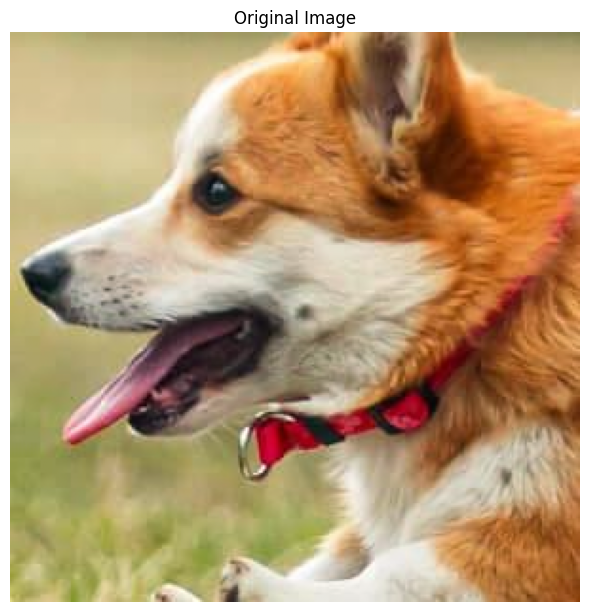

In [5]:
image = torchvision.io.read_image("sample_images/dogCropped.jpg")
image = image.to(device)
image = image.permute(1,2,0)
image_np = image.cpu().numpy()
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
image_np = scaler.fit_transform(image_np.reshape(-1, image_np.shape[-1])).reshape(image_np.shape)
image = torch.tensor(image_np).to(device)
plot_images([image], ["Original Image"])


#### Defining the Linear regressor Model

In [11]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


def create_coordinate_map(img: torch.Tensor)-> tuple[torch.Tensor, torch.Tensor]:
    """
    img shape: (height, width, num_channels)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    height, width, num_channels = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1)

    # Reshape image for mapping
    Y = img.reshape(-1, num_channels)
    return X, Y

# function to create RFF features
def create_rff_features(X:torch.Tensor, num_features: int, sigma: float):
    """
    creates feature space using Radial basis function on Random fourier features on the tensor X  
    X (torch.Tensor): input tensor  
    num_features: number of features to generate  
    sigma: sigma to calculate gamma of RBF kernel   
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=696)    # manually seeding to maintain reproducibility across function calls.
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


def train(net: nn.Module, lr: float, X:torch.Tensor, Y:torch.Tensor, epochs: int, verbose=True)->float:
    """
    net: torch.nn.Module  
    lr: float  
    X: torch.Tensor of shape (num_samples, 2)  
    Y: torch.Tensor of shape (num_samples, 3)  
    returns:  
    final MSE loss value after training
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    Y = Y.float()

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

#### Patching the Image

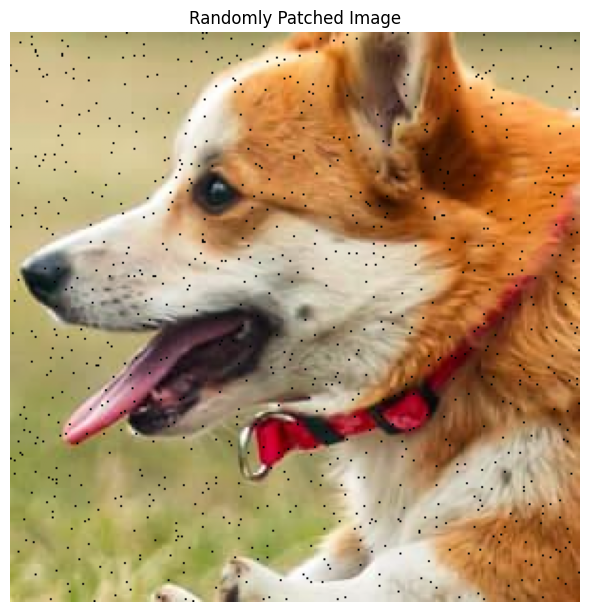

In [12]:
randomlyPatchedImage = image.clone().detach()
mask = np.random.rand(*randomlyPatchedImage.shape[:2]) < 0.01  # 1% of the image will be masked
randomlyPatchedImage[mask, : ] = 0
plot_images([randomlyPatchedImage], ["Randomly Patched Image"])

#### Creating Feature Space for training the model

In [13]:
#getting coordinate mapping and scaling the coordinate values of the pixels
X_coords, Y_values = create_coordinate_map(image)

# MinMaxScaler from -1 to 1
X_coords_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_coords)
# converting to float32 tensor
X_coords_scaled = torch.tensor(X_coords_scaled, device=device).float()
X_coords_scaled.shape

torch.Size([90000, 2])

#### Function for Reconstruction

In [16]:
def reconstruct(X: torch.Tensor, X_img_shape: tuple[int, int, int], Y: torch.Tensor, num_rff: int):
    """
    X - X Feature space of original image
    X_img_shape - Shape of the original image
    Y - Y feature space of original image
    patched - Patched image
    num_rff - Number of random fourier features to generate
    """

    sigma = 0.008
    epochs = 1000
    lr = 0.01

    X_coords_rff = create_rff_features(X, num_rff, sigma)

    # Create a linear model
    rff_model = LinearModel(X_coords_rff.shape[1], Y.shape[1])
    rff_model.to(device)

    # Train the model
    loss = train(rff_model, lr, X_coords_rff, Y, epochs, verbose=True)

    height, width, num_channels = X_img_shape[0], X_img_shape[1], X_img_shape[2]

    rff_model.eval()
    with torch.inference_mode():
        #getting prediction
        Y_pred = rff_model(X_coords_rff)
        reconstructed_image = Y_pred.reshape(height, width, num_channels)

    plot_images([image, reconstructed_image], ["Original Image", "Reconstructed Image"])
    
    mse = MeanSquaredError(device=device)
    psnr = PeakSignalNoiseRatio(device=device)
    mse.update(reconstructed_image.reshape(-1), image.reshape(-1))
    mse_val = mse.compute().item()
    psnr.update(reconstructed_image.reshape(-1), image.reshape(-1))
    psnr_val = psnr.compute().item()

    print(f"MSE: {mse_val:.6f}, PSNR: {psnr_val:.6f}")
    
    del X_coords_rff
    del rff_model 


Epoch 0 loss: 0.364479
Epoch 500 loss: 0.001482
Epoch 1000 loss: 0.000581


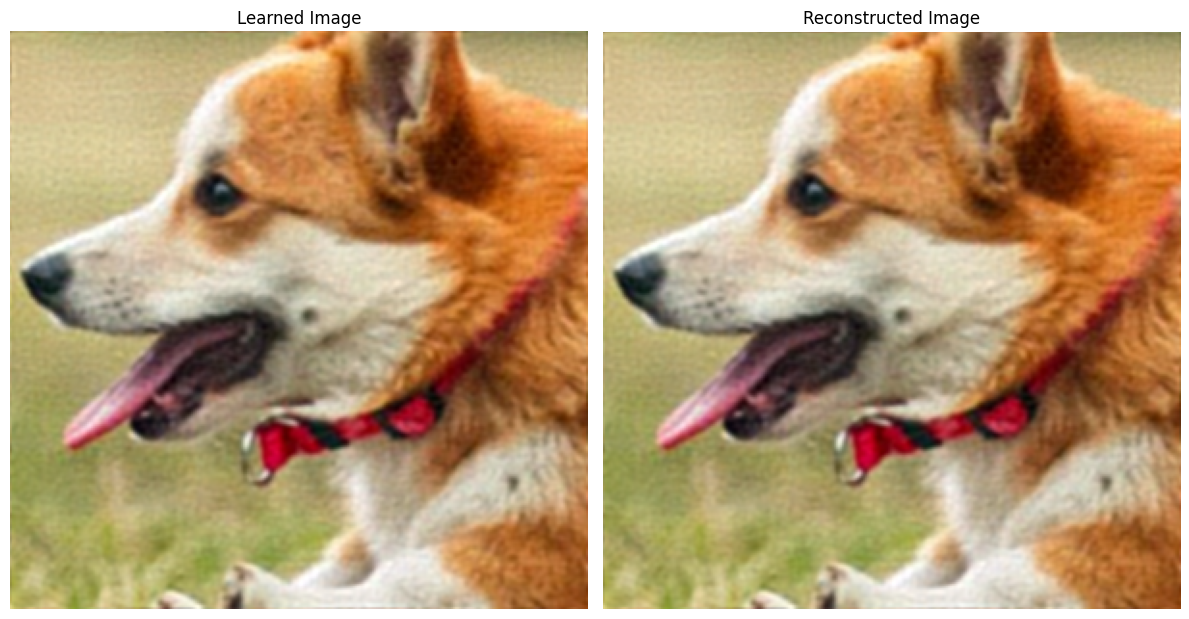

MSE: 0.000581, PSNR: 32.359315


In [17]:
reconstruct(X_coords_scaled, image.shape, Y_values, 15000)

#### Results
As we can see the code using NMF takes less time and space for predicting the image, while also getting a higher value of PSNR. Therefore, Non negative Matrix Factorization is a better method in this case.

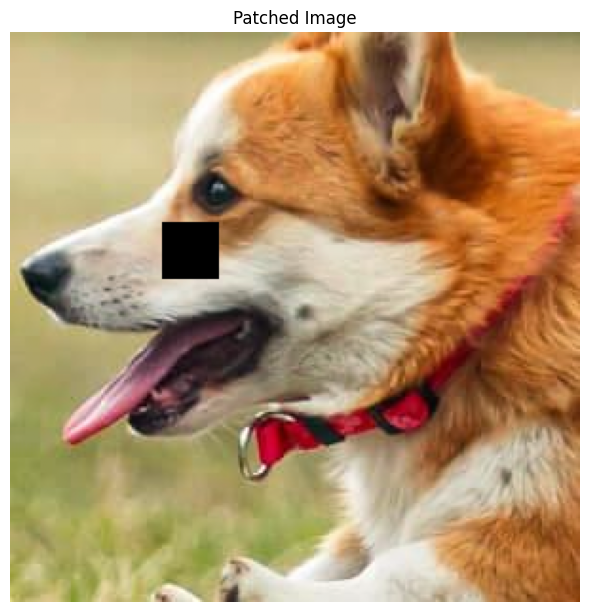

In [13]:
patchedImage = image.clone().detach()

patchedImage[100:130, 80:110,:] = 0

plot_images([patchedImage], ["Patched Image"])

In [ ]:
reconstruct(X_coords_scaled, image.shape, Y_values, patchedImage, 15000)